## Proximity Learning with CatBoost

This Python code trains a **CatBoost regression model** and computes **instance similarity** based on **proximity learning**. The similarity between two instances is determined by how frequently they appear in the same **leaf node** across trees, with an additional weight based on **tree importance**.

---

## Similarity Computation

We use **Equation (2)** and **Equation (3)** to compute instance similarity.

### Equation (2): Instance Similarity Score

$$
P(i,j) = \frac{1}{N} \sum_{t=1}^{N} \Delta_t \cdot I_t(v(j) = v(i))
$$

where:
- \( N \) is the **total number of trees**.
- \( I_t(v(j) = v(i)) \) is **1 if two instances share a leaf** in tree \( t \), otherwise **0**.
- \( \Delta_t \) is the **importance of tree** \( t \), computed as:

### Equation (3): Tree Importance

$$
\Delta_t = \frac{E(t) - E(t-1)}{\sum_{t=1}^{N} (E(t) - E(t-1))}
$$

where:
- \( E(t) \) is the **error of the model** after tree \( t \).
- The difference \( E(t) - E(t-1) \) measures the **impact of tree \( t \) in reducing error**.

---

## Intuition

- **Instance similarity** is based on **how often instances appear in the same leaf** across trees.
- Trees with **higher importance** (greater error reduction) **contribute more** to the similarity score.
- This approach captures **local relationships** rather than relying on global distance metrics.

This method enhances **interpretability** and **clustering** in machine learning models by leveraging the structure of **gradient boosting decision trees** (GBDTs) like CatBoost.

---

## Step 1: Import Necessary Libraries

In [337]:
import numpy as np
import catboost
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, roc_auc_score

## Step 2: Loading and Processing Data from AdBench

In [340]:
# List of datasets to use
datasets = ['2_annthyroid', '5_campaign', '39_vertebral','11_donors','12_fault','18_Ionosphere', '24_mnist','30_satellite','33_skin']

def load_dataset(dataset):
    path = f'/Users/langatkipkemoivincent/Desktop/ssalad/jupyter/data/{dataset}.npz'
    data = np.load(path, allow_pickle=True)
    return data['X'], data['y']


## Step 3: Defining Function to Train CatBoost and Compute Similarity

In [343]:
def compute_similarity(X, y, active_learning_fraction=0.2, query_strategy='clusters'):
    # Ensure stratified split to maintain class balance
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    n_labeled = int(active_learning_fraction * len(X_train))
    
    # Ensure label diversity
    unique_labels = np.unique(y_train)
    if len(unique_labels) == 1:
        raise ValueError("Training set has only one unique target value. Adjust sampling method.")
    
    # Active Learning: Query Strategy - Clusters
    kmeans = KMeans(n_clusters=n_labeled, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_train)
    
    # Select representative points for labeling
    selected_indices = []
    for cluster in np.unique(cluster_labels):
        cluster_indices = np.where(cluster_labels == cluster)[0]
        selected_indices.append(cluster_indices[0])  # Pick first point in each cluster
    
    X_labeled, y_labeled = X_train[selected_indices], y_train[selected_indices]
    X_unlabeled, y_unlabeled = np.delete(X_train, selected_indices, axis=0), np.delete(y_train, selected_indices, axis=0)
    
    # Train CatBoost Regressor on labeled data
    model = CatBoostRegressor(iterations=100, learning_rate=0.1, depth=6, verbose=0)
    model.fit(X_labeled, y_labeled)
    
    # Predict labels for the unlabeled dataset using the trained model
    y_unlabeled = model.predict(X_unlabeled)
    
    # Retrain model with expanded labeled dataset
    X_labeled = np.vstack((X_labeled, X_unlabeled))
    y_labeled = np.hstack((y_labeled, y_unlabeled))
    #model.fit(X_labeled, y_labeled)
    
    # Evaluate model performance using AUC, ensuring multiple classes exist
    y_test_preds = model.predict(X_test)
    if len(np.unique(y_test)) > 1:
        auc_score = roc_auc_score(y_test, y_test_preds)
        print(f"Model AUC Score: {auc_score:.4f}")
    else:
        print("Skipping AUC calculation: y_test contains only one class.")
    
    # Get leaf indices for each instance
    leaf_indices_train = model.calc_leaf_indexes(X_labeled)
    
    # Compute errors for tree importance
    train_preds = model.predict(X_labeled)
    errors = np.square(train_preds - y_labeled)
    
    tree_errors = [
        mean_squared_error(y_labeled, np.array(list(model.staged_predict(X_labeled, ntree_end=i))[-1]))
        for i in range(1, model.tree_count_ + 1)
    ]
    
    tree_errors = np.array(tree_errors)
    
    # Compute tree importance
    delta_t = np.diff(tree_errors, prepend=0)
    delta_t = np.abs(delta_t)
    delta_t /= np.sum(delta_t)
    
    # Compute similarity scores
    num_trees = model.tree_count_
    similarity_matrix = np.zeros((len(X_labeled), len(X_labeled)))
    
    for t in range(num_trees):
        leaf_assignments = leaf_indices_train[:, t]
        for i in range(len(X_labeled)):
            for j in range(len(X_labeled)):
                if leaf_assignments[i] == leaf_assignments[j]:
                    similarity_matrix[i, j] += delta_t[t]
    
    similarity_matrix /= num_trees
    
    # Ensure all values are positive using Min-Max scaling
    scaler = MinMaxScaler()
    similarity_matrix = scaler.fit_transform(similarity_matrix)
    
    return similarity_matrix, model


## Step 4: Training Model and Computing Similarity for Each Dataset

In [346]:
results = {}
for dataset in datasets:
    print(f'Processing {dataset}...')
    X, y = load_dataset(dataset)
    
    # Sub-sample 1000 instances (or full dataset if smaller)
    sample_size = min(100, len(X))  # Ensure we don't exceed dataset size
    indices = np.random.choice(len(X), sample_size, replace=False)
    X_sample, y_sample = X[indices], y[indices]
    
    # Compute similarity
    similarity_matrix, model = compute_similarity(X_sample, y_sample)
    results[dataset] = {'similarity_matrix': similarity_matrix, 'model': model}

Processing 2_annthyroid...
Model AUC Score: 0.8421
Processing 5_campaign...
Model AUC Score: 0.9216
Processing 39_vertebral...
Model AUC Score: 0.6863
Processing 11_donors...
Model AUC Score: 1.0000
Processing 12_fault...
Model AUC Score: 0.3125
Processing 18_Ionosphere...
Model AUC Score: 0.7802
Processing 24_mnist...
Model AUC Score: 0.5833
Processing 30_satellite...
Model AUC Score: 0.7619
Processing 33_skin...
Model AUC Score: 1.0000


## Step 5: Plotting Similarity Heatmaps

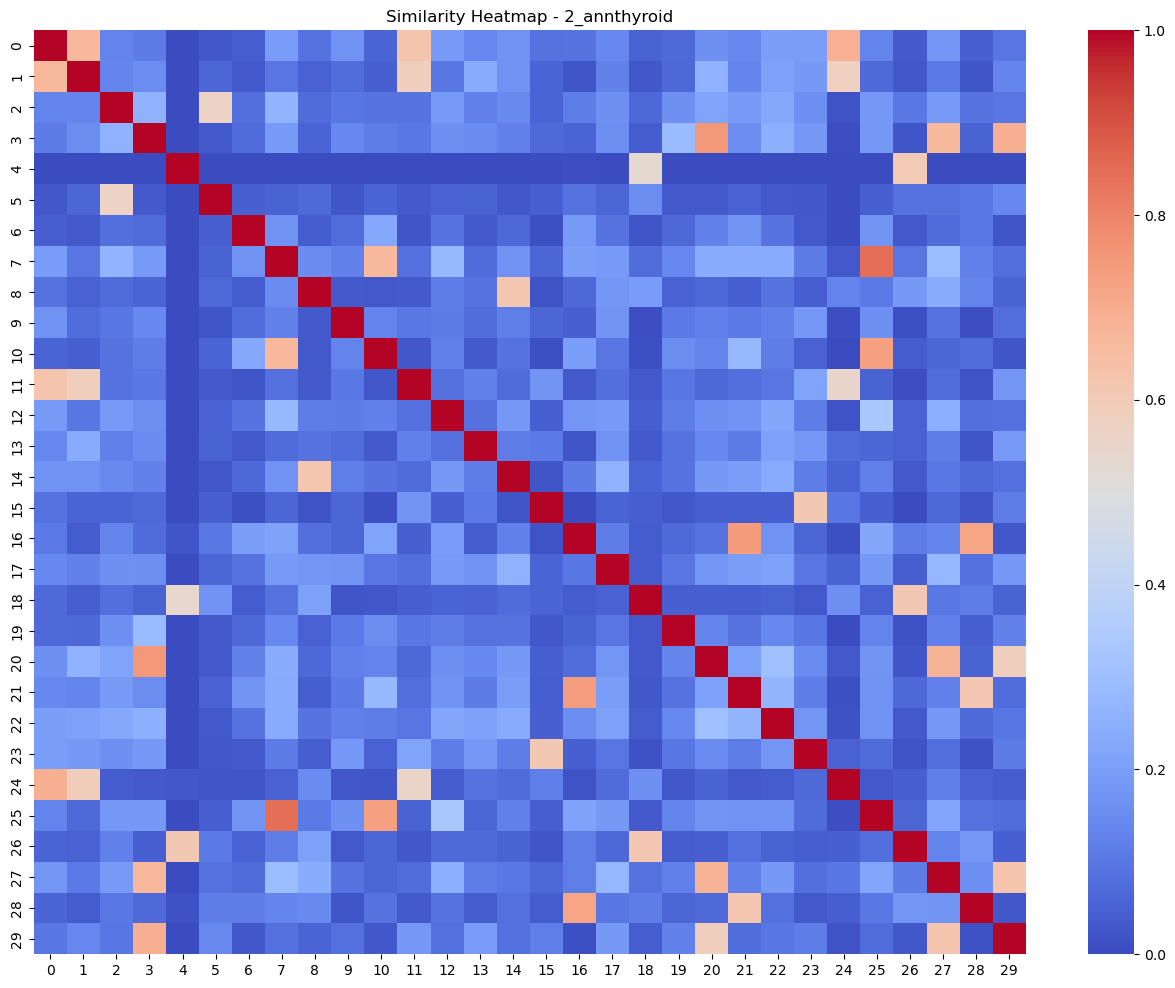

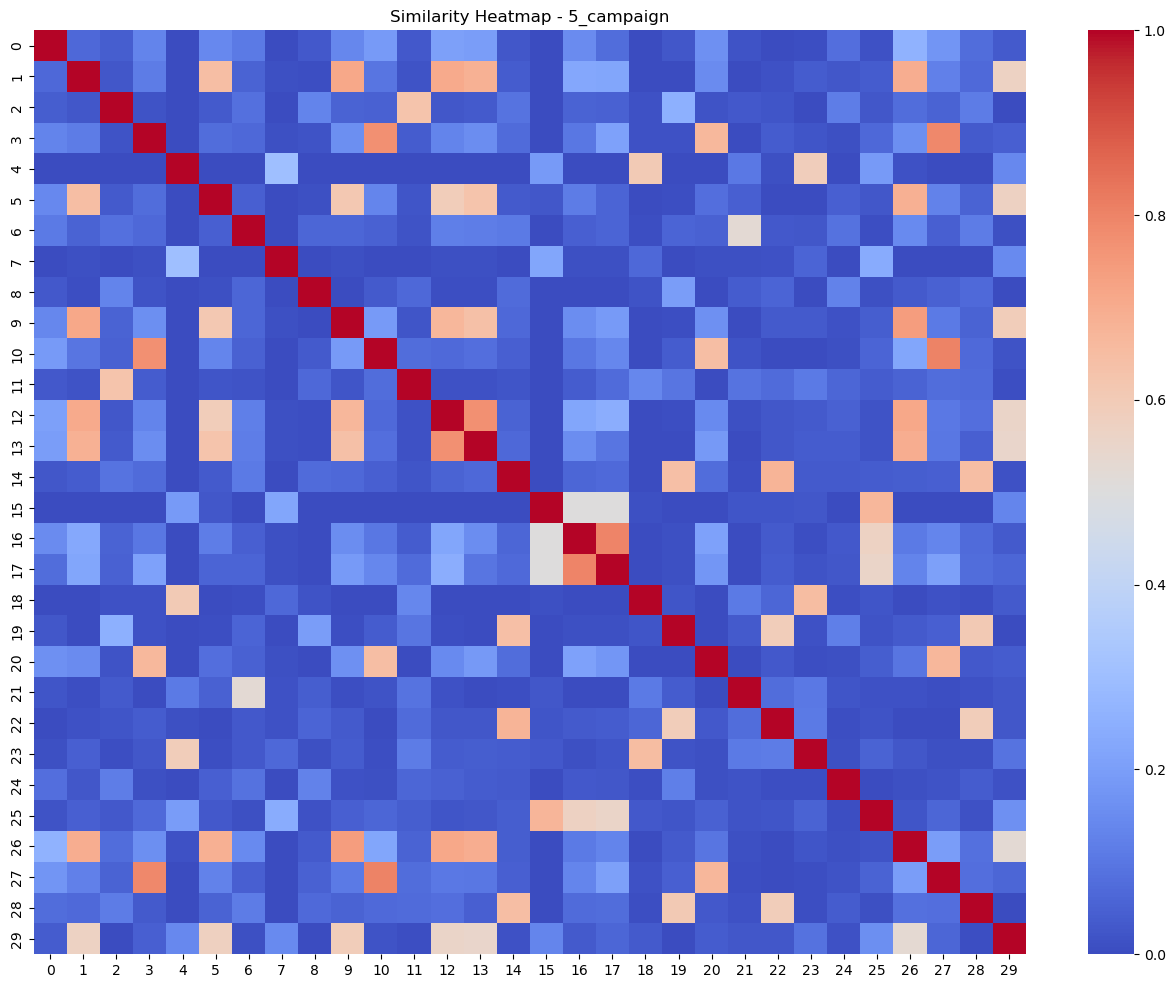

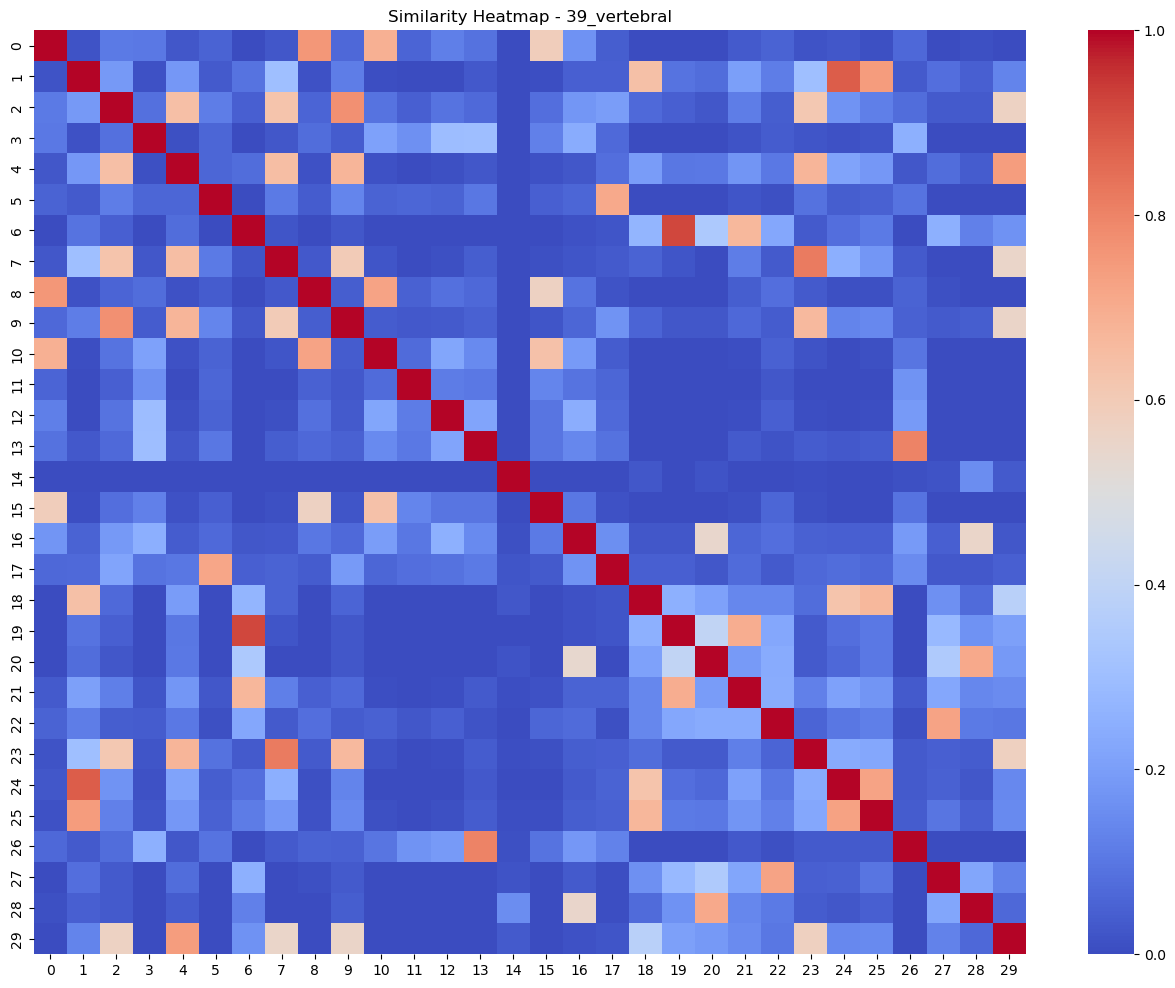

In [ ]:
def plot_similarity(similarity_matrix, dataset_name):
    plt.figure(figsize=(16, 12))
    sns.heatmap(similarity_matrix[:30, :30], cmap='coolwarm', annot=False)
    plt.title(f'Similarity Heatmap - {dataset_name}')
    plt.show()

for i in datasets:
    plot_similarity(results[i]['similarity_matrix'], i)

In [ ]:
import pandas as pd

def display_similarity_dataframe(dataset_name):
    """
    Display the similarity matrix as a pandas DataFrame.
    """
    if dataset_name not in results:
        print(f"Dataset '{dataset_name}' not found in results.")
        return
    
    similarity_matrix = results[dataset_name]['similarity_matrix']
    
    # Convert NumPy array to Pandas DataFrame
    similarity_df = pd.DataFrame(similarity_matrix)

    print(f"Similarity DataFrame for {dataset_name}:")
    display(similarity_df.iloc[:10, :10])  # Show the first 10 rows and columns

# Example: Display similarity DataFrame for '2_annthyroid'


In [ ]:
for i in datasets:
    display_similarity_dataframe(i)
    

In [ ]:
display_similarity_dataframe('5_campaign')

In [ ]:
display_similarity_dataframe('39_vertebral')

## Step 6: Save Model and Results

In [ ]:
with open('proximity_learning_catboost.pkl', 'wb') as f:
    pickle.dump(results, f)

## Final Thoughts

This method calculates instance similarity using CatBoost trees, where:

- **More co-occurrences in the same leaf** → Higher similarity.  
- **More important trees contribute more to similarity.**  

### This is useful for:  
✅ **Anomaly detection**  
✅ **Clustering similar data points**  
✅ **Feature engineering for recommendation systems**  
